
# Notebook to Evaluate / Compare Neural Networks

You'll need h5 and json files for a model to use this.
If you don't have those, you'll have to train a network.

Also, use this to send the csv to others after making a network,
rather than using the csv from when the model's created, since that
uses scaling parameters for the test subset rather than the whole
dataset (they shouldn't be much different but just fyi).

Imports, open file

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import numpy as np
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read().strip("\n")
    
s_table = tools.open_file(filename, sort_by="tag")
print(len(s_table.resolved_lv.pt), 'total events')

Using TensorFlow backend.
sorting data by tag
777150 total events


In [2]:
print(len(s_table[(s_table.nbtags==5) & (s_table.nbjets==4)]))
print(len(s_table[(s_table.nbtags==4) & (s_table.nbjets==4)]))
print(len(s_table[(s_table.nbtags==3) & (s_table.nbjets==4)]))
print(len(s_table[(s_table.nbtags==2) & (s_table.nbjets==4)]))
print(len(s_table[(s_table.nbtags==1) & (s_table.nbjets==4)]))
print(len(s_table[s_table.nbjets==4]))

print()
print(len(s_table[(s_table.nbtags==1) & (s_table.nbjets==4)]))



2232
129546
172594
93760
3123
401544

3123


Filter events

In [3]:
nt3 = s_table.nbtags==3  # 3 b tags
events = s_table[nt3]
print(len(events), 'events with 3 tags')


cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

313660 events with 3 tags


Create network

In [4]:
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("models/architecture_23_07_2020.json", "models/weights_23_07_2020.h5"), njets=10, chop=0, print_summary=True)

Loading model... 
Using architecture: models/architecture_23_07_2020.json 
and weights: models/weights_23_07_2020.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 700)               21700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               150300    
___

Evaluate network

100%|██████████| 313660/313660 [00:04<00:00, 67996.49it/s]
overall accuracy: 59.99 percent
ignoring 2.61 percent (8197 events) of 313660 events


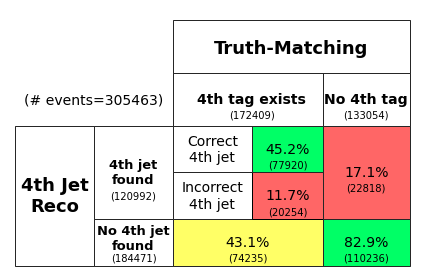

In [5]:
selections = nn.evaluate(events)

Make csv with scaling parameters, 

100%|██████████| 313660/313660 [00:05<00:00, 62118.98it/s]
overall accuracy: 59.99 percent
ignoring 2.61 percent (8197 events) of 313660 events


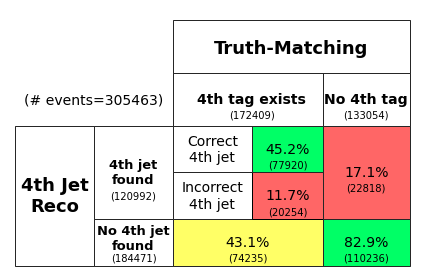

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
truth = events.truth
tag = events.tag

# give people the csv from here when trying to compare models
nn_inputs = tools.scale_nn_input(events, chop=0, save_csv="models/scaling_parameters_06_07_2020_v2")

# get model outputs
scores = nn.model.predict(nn_inputs)

# convert nn scores into "selections"
select=np.argmax(scores,axis=-1)
selections = np.zeros((len(scores), len(tag[0])+1), dtype=int)
for i, s in enumerate(select):
    selections[i][s+3] = 1
    
# chop off the last "no selection" jet
selections = selections[:,:-1]

# evaluate again
tools.evaluate_model(truth, tag, selections)

Get network inputs and outputs for a specific event, to allow event-by-event comparison between models

In [7]:
i_to_compare = 297
print("Event",i_to_compare)
print("Inputs",nn_inputs[i_to_compare])
print("Outputs")
for j in range(len(scores[i_to_compare])):
    print("  ",j,round(scores[i_to_compare][j],4))
print("")

Event 297
Inputs [-6.18521214e-01 -1.88911140e-01  1.77924782e-02 -3.27163865e-03
  2.31345296e-01  2.48493180e-01  1.06336164e+00 -3.29360187e-01
 -1.94782004e-01 -1.10037595e-01  7.36411512e-01  5.15906364e-02
  1.81509364e+00  1.71740949e+00  6.52299374e-02  1.37767816e+00
 -8.48666608e-01 -2.05967342e-03  1.09038805e-03 -2.64976034e-03
 -5.47137439e-01 -2.64361918e-01  1.04922152e+00  1.49571919e+00
 -1.61229396e+00  9.07914102e-01  8.25049222e-01 -4.05969005e-03
  1.08107855e-03  2.81306473e-03]
Outputs
   0 0.9214
   1 0.0
   2 0.0065
   3 1e-04
   4 0.0
   5 0.0
   6 0.0
   7 0.072

